In [34]:
import geopandas as gpd
import pandas as pd
from shapely.geometry import Polygon, MultiPolygon, LineString, mapping, Point
import numpy as np
import itertools
import rtree
pd.set_option('max_columns', None)
%matplotlib inline


street_segments = gpd.read_file("../data/processed/street_segments.geojson")
blocks = gpd.read_file("../data/processed/blocks.geojson")
buildings = gpd.read_file("../data/processed/buildings.geojson")
blockfaces = gpd.read_file("../data/processed/blockfaces.geojson")

In [233]:
def filter_on_block_id(block_id, block_id_key="geoid10"):
    def select(df):
        return (df.set_index(block_id_key)
                    .filter(like=block_id, axis='rows')
                    .reset_index()
               )
    
    return select


def get_block_data(block_id):
    ss = street_segments.pipe(filter_on_block_id(block_id))
    bf = blockfaces.pipe(filter_on_block_id(block_id))
    bldgs = buildings.pipe(filter_on_block_id(block_id))
    return ss, bf, bldgs


def plot_block(block_id):
    street_segments, blockfaces, buildings = get_block_data(block_id)
    
    ax = street_segments.plot(color='red', linewidth=1)
    blockfaces.plot(color='black', ax=ax, linewidth=1)
    buildings.plot(ax=ax, color='lightsteelblue', linewidth=1, edgecolor='steelblue')
    return ax


def simplify_linestring(inp):
        inp = inp.convex_hull
        coords = np.round(mapping(inp)['coordinates'], decimals=4)
        out = LineString(coords)
        return out
    
    
def simplify_bldg(bldg):
    if isinstance(bldg, MultiPolygon):
        bldg = bldg.buffer(0)
    
    if isinstance(bldg, MultiPolygon):
        raise NotImplemented  # TODO
    
    coords = [xyz[:2] for xyz in mapping(bldg.convex_hull)['coordinates'][0]]
    bldg = Polygon(bldg)
    
    return bldg


def pairwise_combinations(keys):
    return itertools.combinations({'a': 12, 'b': 15, 'c': 13}.keys(), r=2)


def collect_strides(point_observations):
    point_obs_keys = list(point_observations.keys())
    curr_obs_start_offset = point_obs_keys[0]
    curr_obs_start_bldg = point_observations[point_obs_keys[0]]    
    strides = dict()
    
    for point_obs in point_obs_keys[1:]:
        bldg_observed = point_observations[point_obs]
        if bldg_observed != curr_obs_start_bldg:
            strides[(curr_obs_start_offset, point_obs)] = curr_obs_start_bldg
            curr_obs_start_offset = point_obs
            curr_obs_start_bldg = bldg_observed
        else:
            continue
            
    strides[(curr_obs_start_offset, '1.00')] = bldg_observed
            
    return strides


def get_stride_boundaries(strides, step_size=0.02):
    boundaries = list()
    
    keys = list(strides.keys())
    for idx, key in enumerate(keys[1:]):
        curr = strides[key]
        boundaries.append((key[0], str(float(key[0]) + step_size)))

    return boundaries


def cut(line, distance):
    # Cuts a line in two at a distance from its starting point
    if distance <= 0.0 or distance >= 1.0:
        return [LineString(line)]
    coords = list(line.coords)
    for i, p in enumerate(coords):
        pd = line.project(Point(p), normalized=True)
        if pd == distance:
            return [
                LineString(coords[:i+1]),
                LineString(coords[i:])]
        if pd > distance:
            cp = line.interpolate(distance, normalized=True)
            return [
                LineString(coords[:i] + [(cp.x, cp.y)]),
                LineString([(cp.x, cp.y)] + coords[i:])]

        
def chop_line_segment_using_offsets(line, offsets):
    offset_keys = list(offsets.keys())
    out = []
    
    for off_start, off_end in offset_keys:
        cut_result = cut(line, float(off_end))
        if len(cut_result) == 1:
            out.append(cut_result[0])
        else:
            to_out, rest = cut(line, float(off_end))
            out.append(to_out)
            line = rest
        
    return out


def frontages_for_blockface(bldgs, blockface, step_size=0.01):
    index = rtree.Rtree()
    for idx, bldg in bldgs.iterrows():
        index.insert(idx, bldg.geometry.bounds)
    
    bldg_frontage_points = dict()
    
    search_space = np.arange(0, 1, step_size)
    next_search_space = []
    while len(search_space) > 0:
        for offset in search_space:
            search_point = blockface.geometry.interpolate(offset, normalized=True)
            nearest_bldg = list(index.nearest(search_point.bounds, 1))[0]
            bldg_frontage_points[str(offset)[:6]] = nearest_bldg
            
        strides = collect_strides(bldg_frontage_points)
        search_space = next_search_space
        
    # convert the list of strides to a proper GeoDataFrame
    out = []
    for sk in strides.keys():
        srs = bldgs.loc[strides[sk], ['geoid10', 'sf16_BldgID']]
        srs['geoid10_n'] = blockface['geoid10_n']
        srs['geom_offset_start'] = sk[0]
        srs['geom_offset_end'] = sk[1]
        # out_geom = cut_line_segment_between_offsets(blockface.geometry, sk[0], sk[1])
        # srs['geometry'] = out_geom
        # TODO: find some way of determining the geometry.
        out.append(srs)
    
    out = gpd.GeoDataFrame(out)
    
    geoms = chop_line_segment_using_offsets(blockface.geometry, strides)
    out['geometry'] = geoms

    return out

In [163]:
model_street_segments, model_blockfaces, model_buildings = get_block_data('060759809001134')

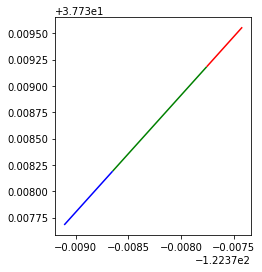

In [235]:
frontages_for_blockface(model_buildings, model_blockfaces.iloc[0]).plot(color=['red', 'green', 'blue'])